In [1]:
import torch
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments
from tqdm import tqdm

/home/anthonyp57/miniconda3/envs/BloodMNIST_wsi_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(torch.cuda.get_device_name(0))
    print(torch.cuda.get_device_properties(0))
else:
    device = torch.device("cpu")
    print("using CPU, GPU is not available")

NVIDIA GeForce RTX 4060 Ti
_CudaDeviceProperties(name='NVIDIA GeForce RTX 4060 Ti', major=8, minor=9, total_memory=16379MB, multi_processor_count=34, uuid=b94096d9-a448-c5c8-aacb-e7f2e7d48103, pci_bus_id=1, pci_device_id=0, pci_domain_id=0, L2_cache_size=32MB)


In [3]:
model_name = "google/vit-base-patch16-224"
image_processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)

# Load data

In [4]:
from dataset import GetMedMNIST

d_size = 224

train_dataloader = GetMedMNIST(name='PathMNIST', split='train', size=d_size)
valid_dataloader = GetMedMNIST(name='PathMNIST', split='val', size=d_size)
test_dataloader = GetMedMNIST(name='PathMNIST', split='test', size=d_size)

100%|██████████| 12.6G/12.6G [05:30<00:00, 38.2MB/s] 


In [5]:
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=train_dataloader.n_classes,
    id2label={str(i): c for i, c in enumerate(train_dataloader.label_str)},
    label2id={c: str(i) for i, c in enumerate(train_dataloader.label_str)},
    ignore_mismatched_sizes=True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
training_args = TrainingArguments(
  output_dir="./PathMNIST_ViT",
  per_device_train_batch_size=128,
  num_train_epochs=5,
  eval_strategy='epoch',
  save_strategy='epoch',
  fp16=True,
  logging_steps=374,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)


In [7]:
from evaluate import load
import numpy as np

accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="weighted")
  return {**accuracy_score, **f1_score}
     

In [8]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataloader,
    eval_dataset=valid_dataloader,
    tokenizer=image_processor
)

/tmp/ipykernel_76758/80359912.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Train

In [9]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.114900,0.037248,0.987205,0.987146
2,0.014700,0.017033,0.994902,0.994902
3,0.004500,0.019143,0.994702,0.994713
4,0.000500,0.012376,0.996301,0.996301
5,0.000200,0.012352,0.996401,0.996400


TrainOutput(global_step=3520, training_loss=0.019231408604272558, metrics={'train_runtime': 2844.0778, 'train_samples_per_second': 158.216, 'train_steps_per_second': 1.238, 'total_flos': 3.487203317854384e+19, 'train_loss': 0.019231408604272558, 'epoch': 5.0})

In [10]:
trainer.evaluate(test_dataloader)

{'eval_loss': 0.1102771982550621,
 'eval_accuracy': 0.9763231197771588,
 'eval_f1': 0.9762571077737803,
 'eval_runtime': 27.9162,
 'eval_samples_per_second': 257.198,
 'eval_steps_per_second': 32.168,
 'epoch': 5.0}

In [11]:
outputs = trainer.predict(test_dataloader)
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# Evaluation

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

def eval_model(labels, preds):
    cf_matrix = confusion_matrix(labels, preds)
    sns.heatmap(cf_matrix, annot=True, cmap='coolwarm', fmt='.0f')

    acc = accuracy_score(labels, preds)

    f1 = f1_score(labels, preds, average='weighted')

    class_report = classification_report(labels, preds)
    print(f'model accuracy: {acc*100:.2f}, f1 weighted: {f1:.4f}')
    print(class_report)

model accuracy: 97.63, f1 weighted: 0.9763
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1338
           1       1.00      1.00      1.00       847
           2       0.95      1.00      0.98       339
           3       1.00      1.00      1.00       634
           4       1.00      0.99      1.00      1035
           5       0.87      0.97      0.92       592
           6       0.99      0.96      0.97       741
           7       0.95      0.83      0.88       421
           8       0.97      0.99      0.98      1233

    accuracy                           0.98      7180
   macro avg       0.97      0.97      0.97      7180
weighted avg       0.98      0.98      0.98      7180



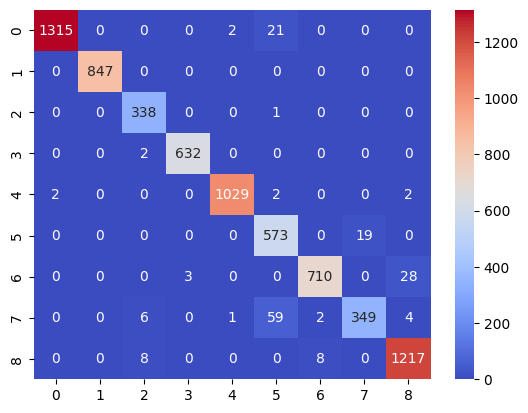

In [13]:
eval_model(y_true, y_pred)

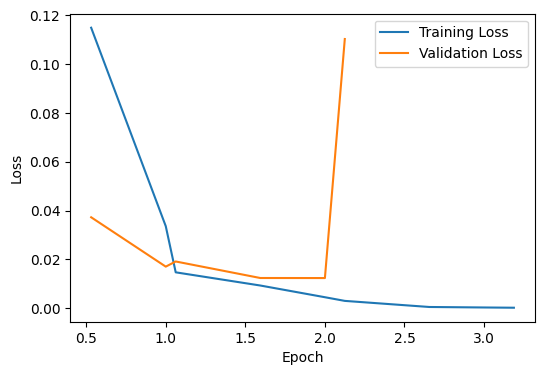

In [14]:
import matplotlib.pyplot as plt

data = trainer.state.log_history
epochs = [entry['epoch'] for entry in data]
train_losses = [entry['loss'] for entry in data if 'loss' in entry]
eval_losses = [entry['eval_loss'] for entry in data if 'eval_loss' in entry]
plt.figure(figsize=(6, 4))

plt.plot(epochs[:len(train_losses)], train_losses, label='Training Loss')
plt.plot(epochs[:len(eval_losses)], eval_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

ROC Score: 0.998


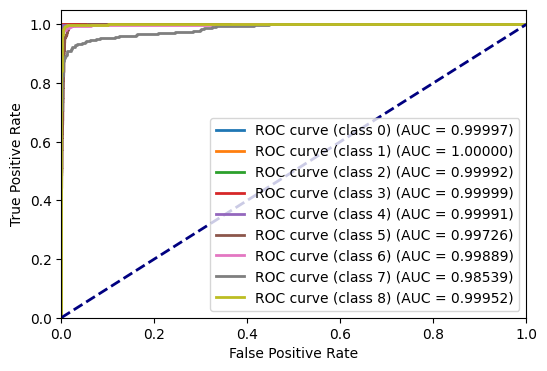

In [15]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import torch

true_labels = outputs.label_ids.reshape(-1)
predictions = torch.softmax(torch.tensor(outputs.predictions), dim=1).numpy()

roc_score = roc_auc_score(true_labels, predictions, multi_class='ovo', average='weighted')
print(f"ROC Score: {roc_score:.3f}")

num_classes = predictions.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((true_labels == i).astype(int), predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 4))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d) (AUC = %0.5f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model_path = "./PathMNIST_ViT/checkpoint-3520"
from transformers import ViTImageProcessor, ViTForImageClassification

model_name = "google/vit-base-patch16-224"

image_processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(
    model_path,
    num_labels=train_dataloader.n_classes,
    id2label={str(i): c for i, c in enumerate(train_dataloader.label_str)},
    label2id={c: str(i) for i, c in enumerate(train_dataloader.label_str)},
    ignore_mismatched_sizes=True,
    image_processor=image_processor
)

NameError: name 'train_dataloader' is not defined